# Data Conditioning 

In [1]:
# %% Sources
# General structure of below script
# https://www.grace-dev.com/python-apis/strava-api/ 

# Multiple pages
# https://medium.com/swlh/using-python-to-connect-to-stravas-api-and-analyse-your-activities-dummies-guide-5f49727aac86


# %% Import
import json
import os
import requests
import time
import pandas as pd

# %% Script params
print_set = False
# nr_act = 100
nr_per_page = 50
page = 1
total_page_nr = 25 # You might want to increase this value, depending on the number of Strava activities you have


# %% ID
# Use first link to fill in these variables
client_id = '104828' # Removed this. Fill in your own ID here!
client_secret = 'be7e0cf3aae82a78b6d1765b6954b6aa7ff4f344' # Removed this. Fill in your own secret here!
redirect_uri = 'http://localhost/'


# %% Get token
def request_token(client_id, client_secret, code):
    response = requests.post(url='https://www.strava.com/oauth/token',
                             data={'client_id': client_id,
                                   'client_secret': client_secret,
                                   'code': code,
                                   'grant_type': 'authorization_code'})
    return response


def write_token(tokens):

    with open('strava_tokens.json', 'w') as outfile:
        json.dump(tokens, outfile)
        

def get_token():

    with open('strava_tokens.json', 'r') as tokens:
        data = json.load(tokens)

    return data


if not os.path.exists('./strava_tokens.json'):
    request_url = f'http://www.strava.com/oauth/authorize?client_id={client_id}' \
                  f'&response_type=code&redirect_uri={redirect_uri}' \
                  f'&approval_prompt=force' \
                  f'&scope=profile:read_all,activity:read_all'

    print('Click here:', request_url)
    print('Please authorize the app and copy&paste below the generated code!')
    print('P.S: you can find the code in the URL')
    code = input('Insert the code from the url: ')

    tokens = request_token(client_id, client_secret, code)

    # Save json response as a variable
    strava_tokens = tokens.json()
    # Save tokens to file
    write_token(strava_tokens)


data = get_token()
print(data)
if data['expires_at'] < time.time():
    new_tokens = request_token(client_id, client_secret, code)
    # Update the file
    write_token(new_tokens)

data = get_token()

access_token = data['access_token']

# %% Athlete
athlete_url = f"https://www.strava.com/api/v3/athlete?" \
              f"access_token={access_token}"
response = requests.get(athlete_url)
athlete = response.json()

# %% Print
if print_set:
    print('RESTful API:', athlete_url)
    print('=' * 5, 'ATHLETE INFO', '=' * 5)
    print('Name:', athlete['firstname'],
          '"' + athlete['username'] + '"', athlete['lastname'])
    print('Gender:', athlete['sex'])
    print('City:', athlete['city'], athlete['country'])
    print('Strava athlete from:', athlete['created_at'])

# %% Activity
activities_url = f"https://www.strava.com/api/v3/athlete/activities?" \
          f"access_token={access_token}"
print('RESTful API:', activities_url)
# response = requests.get(activities_url, perPage = nr_per_page)

page = 1
response = requests.get(activities_url + '&per_page=50' + '&page=' +
                        str(page))
response = response.json()
df = pd.DataFrame(response)

while page < total_page_nr: 
    page += 1
    print(page)
    response = requests.get(activities_url + '&per_page=50' + '&page=' +
                            str(page))
    response = response.json()

    if not(response):
        break

    df_new = pd.DataFrame(response)
    df = df.append(df_new, ignore_index=True)

# print(df)
# %% Output data
df.to_pickle('strava_activities')

{'token_type': 'Bearer', 'expires_at': 1680180252, 'expires_in': 21600, 'refresh_token': '65c499e026aa1147001c31f4307c261b20c2de19', 'access_token': '7294b7dbe5f50f8fb605e12de55853bf57ff643e', 'athlete': {'id': 56675688, 'username': None, 'resource_state': 2, 'firstname': 'Samuel', 'lastname': 'Dixon', 'bio': '', 'city': '', 'state': '', 'country': None, 'sex': 'M', 'premium': False, 'summit': False, 'created_at': '2020-05-01T16:01:29Z', 'updated_at': '2023-03-07T04:18:26Z', 'badge_type_id': 0, 'weight': 0.0, 'profile_medium': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/56675688/26699429/1/medium.jpg', 'profile': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/56675688/26699429/1/large.jpg', 'friend': None, 'follower': None}}
RESTful API: https://www.strava.com/api/v3/athlete/activities?access_token=7294b7dbe5f50f8fb605e12de55853bf57ff643e
2
3
4
5
6
7


# Data Visualization

<IPython.core.display.Javascript object>


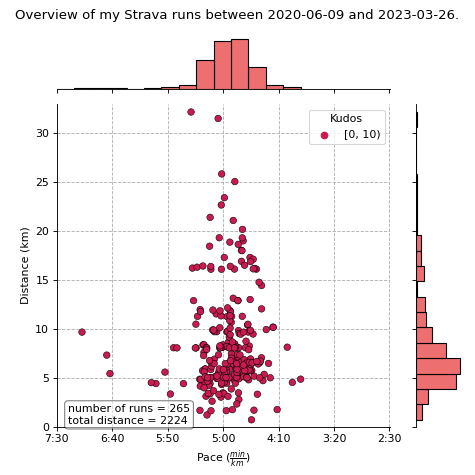

MovieWriter ffmpeg unavailable; using Pillow instead.


In [48]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 23 14:53:36 2022

@author: brababas

For writing to MP4, I used FFMPEG, you can download it here
https://www.gyan.dev/ffmpeg/builds/
"""

# %% Todo


# %% Import
%matplotlib notebook
import pandas as pd
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import math

# %% Script settings
# cmap_ = 'viridis'
cmap_ = 'rocket_r'
# color_ = '#22A884'
# color_ = '#20928C'
color_ = '#E83F3F'
write_mp4 = False
ffmpeg_path = 'test.mp4' # If you want to write to mp4, add the local path of FFMPEG here

# %% Load data
df = pd.read_pickle('strava_activities')
df['start_date_local']= pd.to_datetime(df['start_date_local'])
df_2 = df[(df.type=='Run') & (df.visibility!='only_me')]
df_2 = df_2[(df_2['start_date_local'] > '2019-10-30')]
df_2['average_speed_unit'] = df_2['average_speed']**(-1)*1000 # convert pace from m/s to s/km
df_2['distance'] = df_2['distance']/1000 # distance in km
df_2 = df_2.iloc[::-1].reset_index() # oldest activities first (reverse order)
df_2['cum_distance'] = df_2['distance'].cumsum()

# %% Categorize
kudo_min, kudo_max = df_2.kudos_count.min(), df_2.kudos_count.max()
kudo_bins = np.arange(kudo_min,math.ceil(kudo_max/10)*10 + 10,10)
df_2['Kudos'] = pd.cut(df_2.kudos_count,kudo_bins, right=False)

# %% Plot

# Function to format pace axis in unit minutes:seconds
def format_func(x, pos):
    minutes = int((x%3600)//60)
    seconds = int(x%60)
    return "{:d}:{:02d}".format(minutes, seconds)

def create_title(start_date, cur_date):
    return 'Overview of my Strava runs between {start_date} and {cur_date}.'.format(start_date=start_date, cur_date=cur_date)

def format_plot(g): 
    # X axis in min/km from slow to fast paces
    g.ax_joint.set(xlim=(149, 450)) # You might want to change these values, this is the range of the x-axis in s/km
    g.ax_joint.set(ylim=(0, math.ceil(max(df_2.distance))))
    formatter = FuncFormatter(format_func)
    g.ax_joint.xaxis.set_major_formatter(formatter)
    g.ax_joint.invert_xaxis()

    # Layout of plot
    cur_date = str(df_2.start_date_local.iloc[-1].date())
    title = create_title(start_date, cur_date)
    g.fig.suptitle(title)
    g.fig.tight_layout()
    g.fig.subplots_adjust(bottom=0.1)
    g.fig.subplots_adjust(left=0.12)
    g.ax_joint.set_xlabel(r'Pace ($\frac{min}{km}$)')
    g.ax_joint.set_ylabel('Distance (km)')
    g.ax_joint.grid(linestyle = '--')
    g.ax_joint.set_axisbelow(True)

def prep_axes(g): 
    g.ax_joint.clear()
    g.ax_marg_x.clear()
    g.ax_marg_y.clear()
       
    plt.setp(g.ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(g.ax_marg_y.get_yticklabels(), visible=False)
    plt.setp(g.ax_marg_x.yaxis.get_majorticklines(), visible=False)
    plt.setp(g.ax_marg_x.yaxis.get_minorticklines(), visible=False)
    plt.setp(g.ax_marg_y.xaxis.get_majorticklines(), visible=False)
    plt.setp(g.ax_marg_y.xaxis.get_minorticklines(), visible=False)
    plt.setp(g.ax_marg_x.get_yticklabels(), visible=False)
    plt.setp(g.ax_marg_y.get_xticklabels(), visible=False)

def plot_stats(nr, distance):
    text = '\n'.join(('number of runs = {:.0f}'.format(nr), 'total distance = {:.0f}'.format(distance)))
    return text

start_date = str(df_2.start_date_local[0].date())
g = sns.JointGrid()
format_plot(g)
props = dict(boxstyle='round',facecolor='white', alpha=0.5)

def animate(i): 
    
    # First frame of animation shows all points
    if i==0: 
        data = df_2
        i = len(df_2)
    else: 
        data = df_2[0:i]
    
    x_, y_, z_ = data.average_speed_unit, data.distance, data.Kudos
    
    prep_axes(g)
    format_plot(g)
    
    # Title
    cur_date = str(df_2.start_date_local[i-1].date())
    title = create_title(start_date, cur_date)
    g.fig.suptitle(title)
    
    # summary stats
    stats_text = plot_stats(i, df_2['cum_distance'][i-1])   
    g.ax_joint.text(440,0.3, stats_text, fontsize=10, bbox=props)
        
    #Plot data
    sns.scatterplot(x=x_, y=y_, ax=g.ax_joint, 
                    hue = z_, palette = cmap_, edgecolor='black')
    sns.histplot(x=x_, ax=g.ax_marg_x, fill=True, color=color_, bins=20)
    sns.histplot(y=y_, ax=g.ax_marg_y, fill=True, color=color_, bins=20)


ani = animation.FuncAnimation(g.fig, animate, frames = len(df_2)+1, 
                              interval = 5, repeat = False, blit = False)
ani.save("gauss.gif", fps=240)

if write_mp4:
    plt.rcParams['animation.ffmpeg_path'] = ffmpeg_path
    print(plt.rcParams['animation.ffmpeg_path'])
    writer = animation.FFMpegWriter(fps=60, metadata=dict(artist='Me'), bitrate=1800)